In [128]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np 
import seaborn as sns
import statistics
from scipy import stats
import plotly.express as px
from itertools import chain
import plotly.graph_objects as go

In [73]:
def process_throws_df(path='../data/raw/all_games_0626.csv'):
    throws_df = pd.read_csv(path)
    throws_df.dropna(subset=['thrower_x', 'thrower_y'], inplace=True)
    throws_df['x_change'] = throws_df['receiver_x'] - throws_df['thrower_x']
    throws_df['y_change'] = throws_df['receiver_y'] - throws_df['thrower_y']
    throws_df['radians'] = np.arctan2(throws_df.receiver_y - throws_df.thrower_y, throws_df.receiver_x - throws_df.thrower_x)
    throws_df['degrees'] = np.rad2deg(throws_df['radians'])
    return throws_df
throws_df = process_throws_df()

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_63416/1021503045.py:2: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [2]:
throws_df = pd.read_csv('../data/raw/all_games_0626.csv')

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_27338/484786864.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  throws_df = pd.read_csv('../data/raw/all_games_0626.csv')


In [ ]:
throws_df.dropna(subset=['thrower_x', 'thrower_y'], inplace=True)
throws_df['x_change'] = throws_df['receiver_x'] - throws_df['thrower_x']
throws_df['y_change'] = throws_df['receiver_y'] - throws_df['thrower_y']
throws_df = throws_df[(round(throws_df['x_change'], 1) != 0) | (round(throws_df['y_change'], 1) != 0)]
throws_df['radians'] = np.arctan2(throws_df.receiver_y - throws_df.thrower_y, throws_df.receiver_x - throws_df.thrower_x)
throws_df['degrees'] = np.rad2deg(throws_df['radians'])
non_bricks = throws_df[(throws_df['thrower_x'] != 0) & (throws_df['thrower_y'] != 40)]
turnovers = throws_df[throws_df['turnover'].values == 1]
goals = throws_df[throws_df['receiver_y'] >= 100]
non_brick_turnovers = non_bricks[non_bricks['turnover'].values == 1]

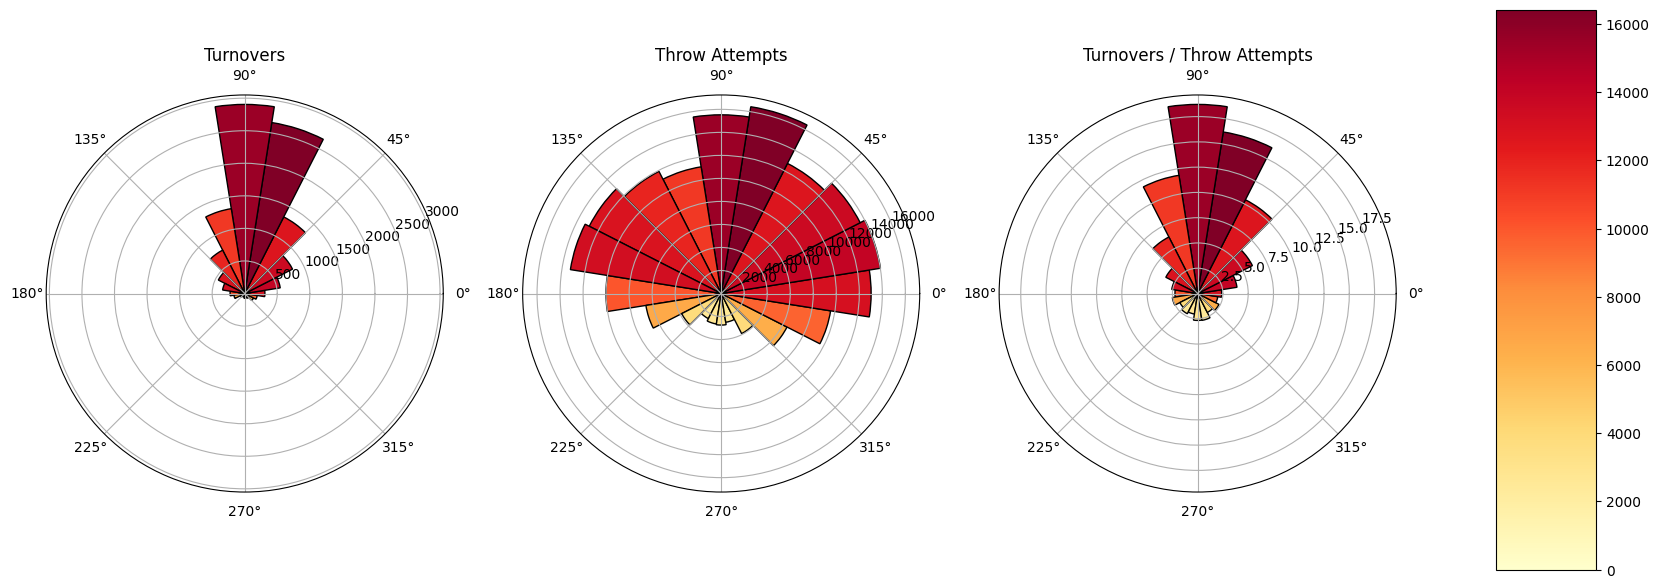

In [5]:
bins=20

throws_count, throws_plot = np.histogram(throws_df.radians, bins=bins, range=(-np.pi, np.pi))
turnovers_count, turnovers_plot = np.histogram(turnovers.radians, bins=bins, range=(-np.pi, np.pi))
ratio_count = turnovers_count/throws_count
norm = mpl.colors.Normalize(vmin=0,vmax=max(throws_count))
colors = plt.cm.YlOrRd(norm(throws_count))
cmap = plt.get_cmap('YlOrRd')
#-- Plotting the colormap in the created axes

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig, axs = plt.subplots(1,3, figsize=(20,8),subplot_kw=dict(projection='polar'))

axs[0].bar(turnovers_plot[:-1], turnovers_count, width=turnovers_plot[0]-turnovers_plot[1], align='center', color=colors, edgecolor='black')
axs[0].title.set_text('Turnovers')

axs[1].bar(turnovers_plot[:-1], throws_count, width=turnovers_plot[0]-turnovers_plot[1], align='center', color=colors, edgecolor='black')
axs[1].title.set_text('Throw Attempts')

axs[2].bar(turnovers_plot[:-1], ratio_count*100, align='center', width=turnovers_plot[0]-turnovers_plot[1], color=colors, edgecolor='black')
axs[2].title.set_text('Turnovers / Throw Attempts')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(sm, cax=cbar_ax)

In [9]:
SLC_GAMES = throws_df[['shred' in x for x in throws_df.home_teamID]]
SLC_GAMES = SLC_GAMES[['2023' in x for x in SLC_GAMES.gameID]]
SLC_GAMES = SLC_GAMES[SLC_GAMES.is_home_team]
all_players = [x[2:-2].replace('\'','').replace(' ', '').split(',') for x in SLC_GAMES[SLC_GAMES.is_home_team].current_line]
team_players = set([item for sublist in all_players for item in sublist])

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_27338/4026933485.py:13: RuntimeWarning: divide by zero encountered in true_divide
  turn_perc = turn_count/count * 100
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_27338/4026933485.py:13: RuntimeWarning: invalid value encountered in true_divide
  turn_perc = turn_count/count * 100
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_27338/4026933485.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


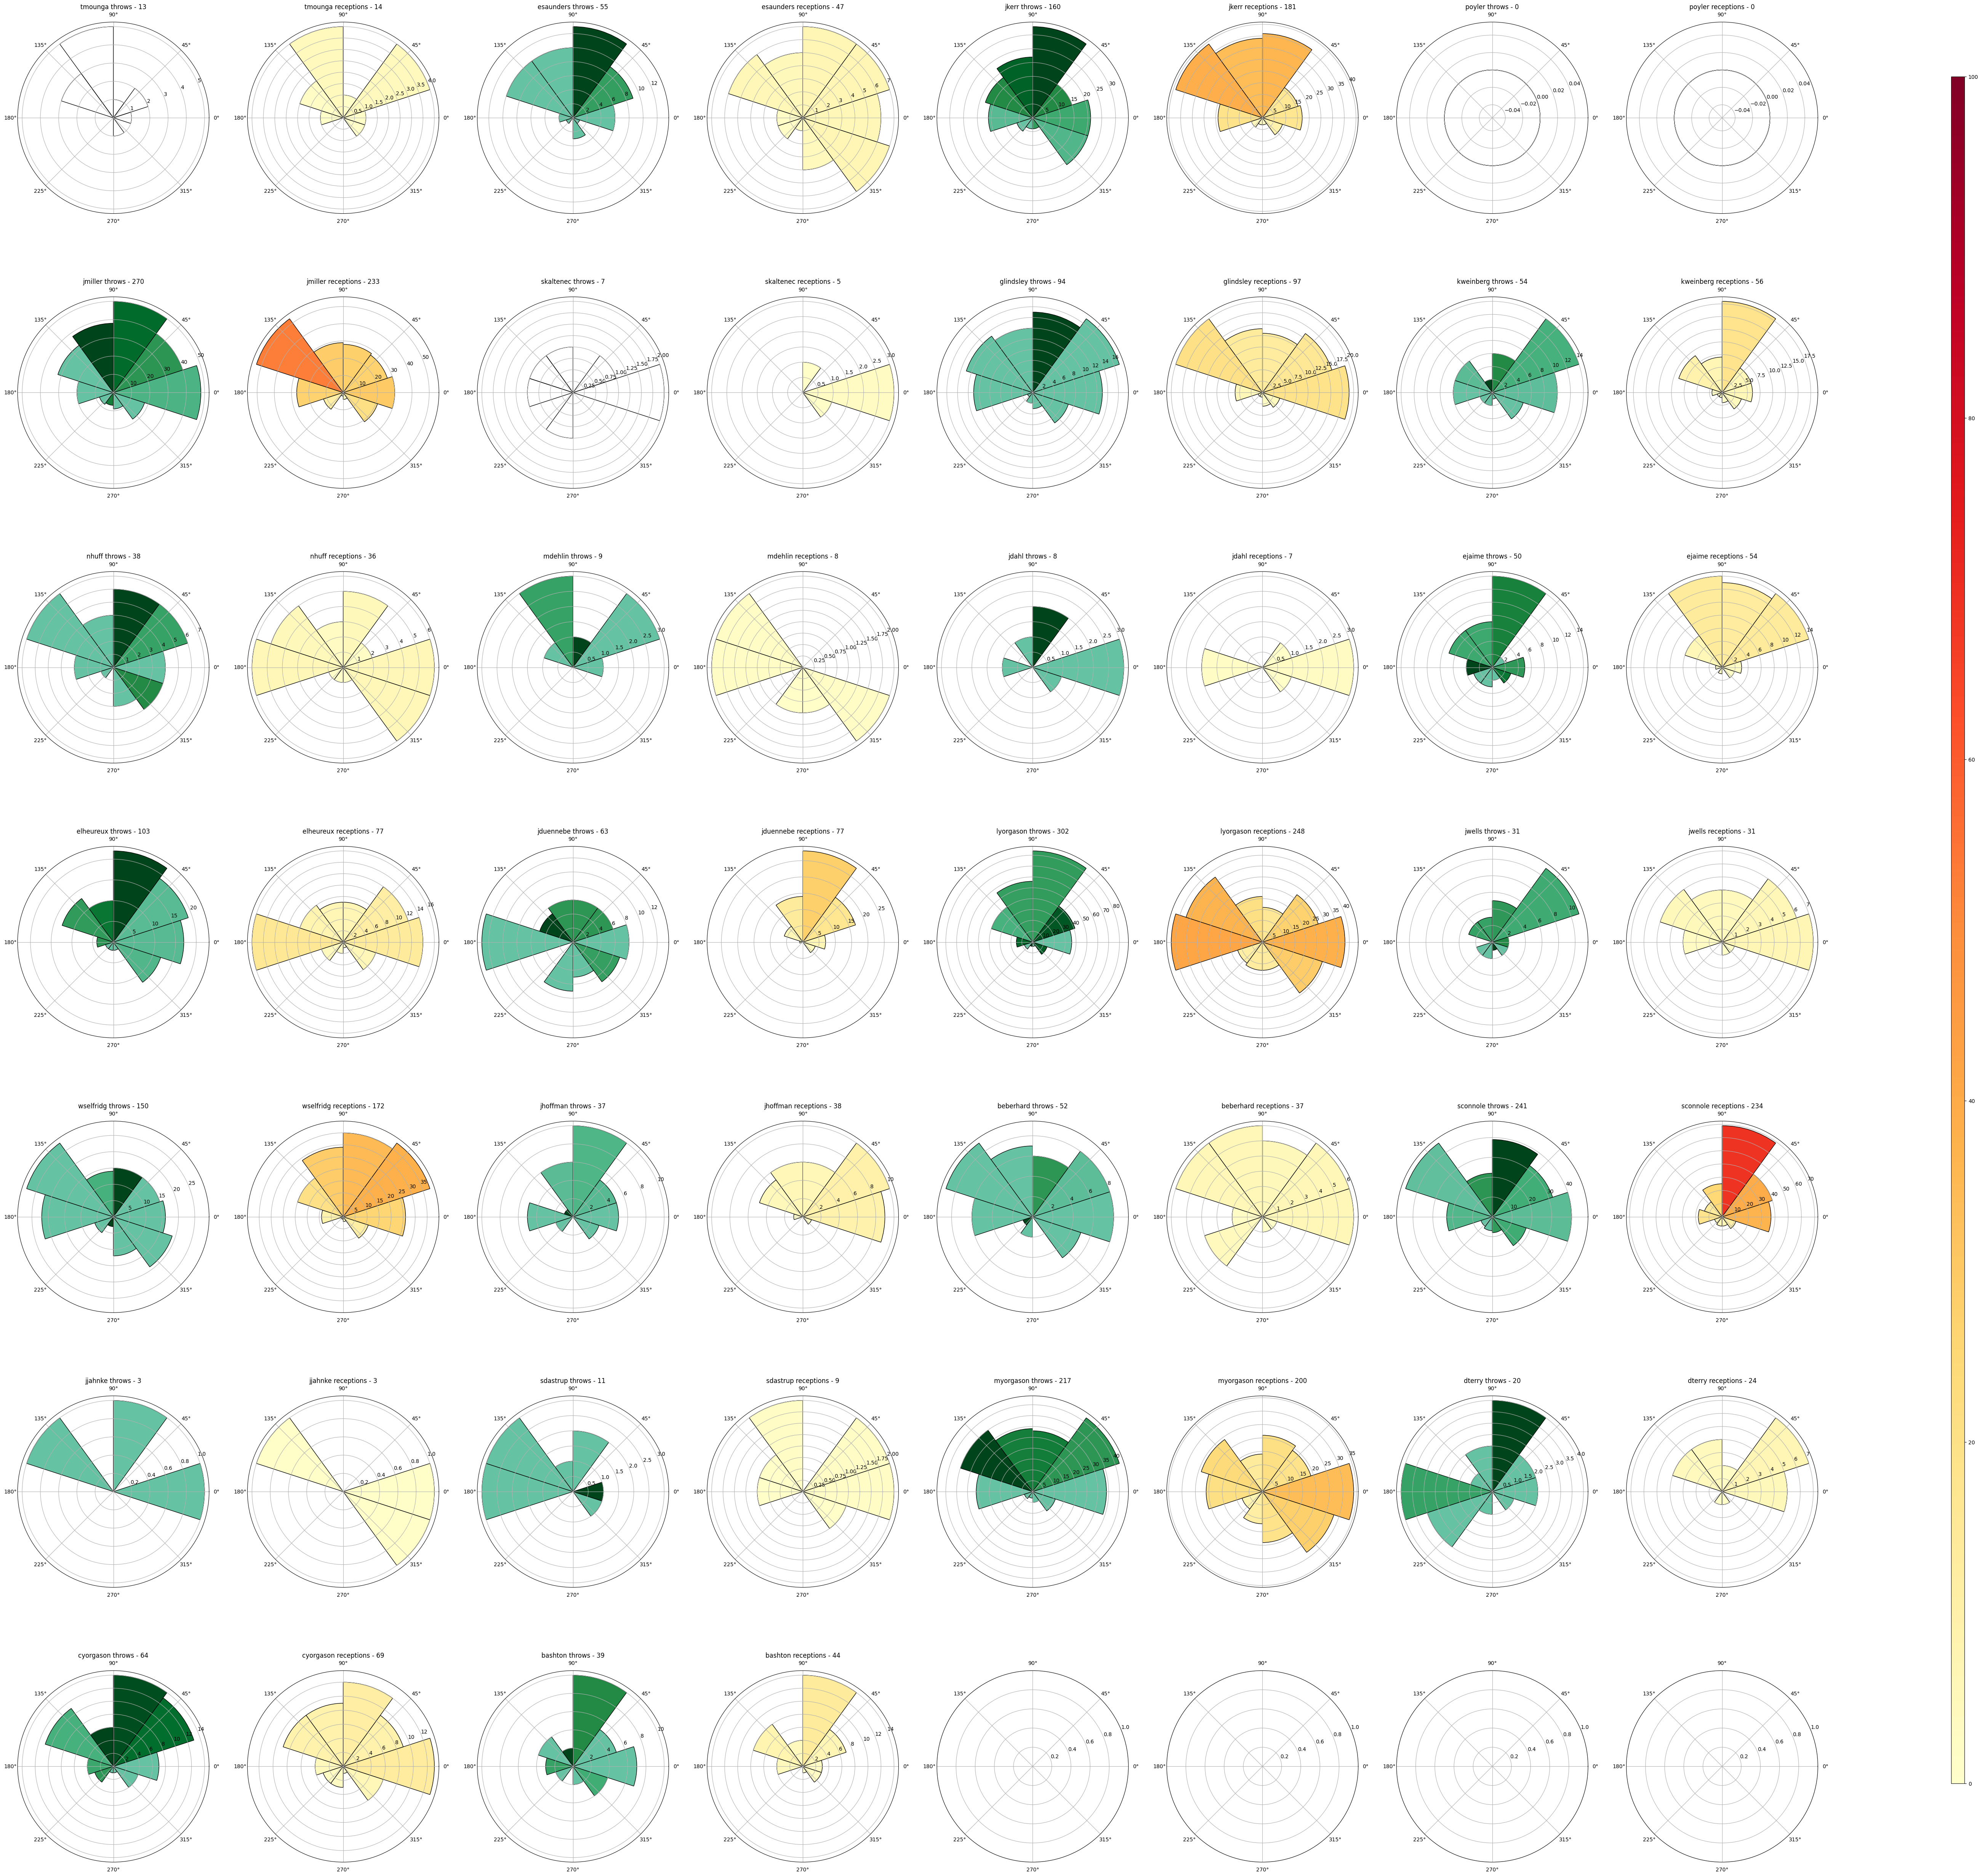

In [27]:
bins = 10

fig, axs = plt.subplots(int(np.ceil(len(team_players)*2 / 8)),8, figsize=(70,64),subplot_kw=dict(projection='polar'))
row = 0
col = 0

usage_norm = mpl.colors.Normalize(vmin=0,vmax=100)
this_year = ['2023' in x for x in throws_df.gameID]
for player in team_players:
    player_df = throws_df[(throws_df['thrower'] == player) & (this_year)].radians
    count, plot = np.histogram(player_df, bins=bins, range=(-np.pi, np.pi))
    turn_count, turn_plot = np.histogram(turnovers[turnovers['thrower'] == player].radians, bins=bins, range=(-np.pi, np.pi))
    turn_perc = turn_count/count * 100

    norm = mpl.colors.Normalize(vmin=-np.nanmax(turn_perc),vmax=np.nanmax(turn_perc))
    if np.nanmax(turn_perc) == 0:
        norm = mpl.colors.Normalize(vmin=-1,vmax=1)


    colors = plt.cm.BuGn(norm(turn_perc))
    axs[row, col].bar(plot[:-1], count, width=plot[0]-plot[1], align='center', color=colors, edgecolor='black')
    axs[row, col].set_title(f'{player} throws - {len(player_df)}')

    player_df = throws_df[(throws_df['receiver'] == player) & (this_year)].radians
    col = col + 1
    count, plot = np.histogram(player_df, bins=bins, range=(-np.pi, np.pi))
    colors = plt.cm.YlOrRd(usage_norm(count))
    axs[row, col].bar(plot[:-1], count, width=plot[0]-plot[1], align='center', color=colors, edgecolor='black')
    axs[row, col].set_title(f'{player} receptions - {len(player_df)}')
    col = col + 1
    if col == 8:
        col = 0
        row = row + 1
fig.subplots_adjust(right=0.8)
cmap = plt.get_cmap('YlOrRd')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=usage_norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
plt.colorbar(sm, cax=cbar_ax)
plt.savefig('./charts/slc_directionality.jpg')
fig.show()

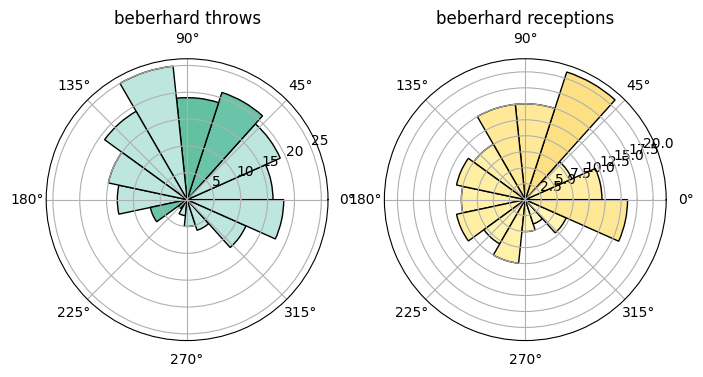

In [21]:
def get_player_graphs(player):
    fig, axs = plt.subplots(1,2, figsize=(8,16),subplot_kw=dict(projection='polar'))
    count, plot = np.histogram(throws_df[throws_df['thrower'] == player].radians, bins=bins, range=(-np.pi, np.pi))
    turn_count, turn_plot = np.histogram(turnovers[turnovers['thrower'] == player].radians, bins=bins, range=(-np.pi, np.pi))
    turn_perc = turn_count/count * 100
    norm = mpl.colors.Normalize(-20,vmax=np.nanmax(turn_perc))
    colors = plt.cm.BuGn(norm(turn_perc))
    axs[0].bar(plot[:-1], count, width=plot[0]-plot[1], align='center', color=colors, edgecolor='black')
    axs[0].set_title(player + ' throws')

    count, plot = np.histogram(throws_df[throws_df['receiver'] == player].radians, bins=bins, range=(-np.pi, np.pi))
    usage_norm = mpl.colors.Normalize(vmin=0,vmax=100)
    colors = plt.cm.YlOrRd(usage_norm(count))
    axs[1].bar(plot[:-1], count, width=plot[0]-plot[1], align='center', color=colors, edgecolor='black')
    axs[1].set_title(player + ' receptions')

bins = 15
get_player_graphs('beberhard')

In [37]:
def calculate_midpoints(sorted_array):
    midpoints = []
    
    for i in range(1, len(sorted_array)):
        midpoint = (sorted_array[i] + sorted_array[i-1]) / 2
        midpoints.append(midpoint)
    
    return midpoints

In [99]:
player='jkerr'
bins=12
count, plot = np.histogram(throws_df[throws_df['thrower'] == player].degrees, bins=bins, range=(-180, 180))
turnover_count, turnover_plot = np.histogram(throws_df[(throws_df['thrower'] == player) & throws_df.turnover].degrees, bins=bins, range=(-180, 180))


In [100]:
plot

array([-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60.,
         90.,  120.,  150.,  180.])

In [176]:
def create_player_bar_polar_chart(player, column='thrower', bins=12):
    if column not in ['thrower', 'receiver']:
        raise ValueError("Invalid column name. Choose either 'thrower' or 'receiver'.")

    count, plot = np.histogram(throws_df[throws_df[column] == player].degrees, bins=bins, range=(-180, 180))
    turnover_count, turnover_plot = np.histogram(
        throws_df[(throws_df[column] == player) & throws_df.turnover].degrees, bins=bins, range=(-180, 180)
    )
    fig = create_bar_polar_chart(count, plot, player, turnover_count, column)
    return fig

def calculate_midpoints(sorted_array):
    midpoints = []
    
    for i in range(1, len(sorted_array)):
        midpoint = (sorted_array[i] + sorted_array[i-1]) / 2
        midpoints.append(midpoint)
    
    return midpoints

def create_bar_polar_chart(count, plot, player, turnover_count, column):
    if column == 'thrower':
        marker_color = count
        hover_text = [f"Total Count: {c}<br>Turnovers: {t} ({t/c*100:.1f}%)<extra></extra>" for c, t in zip(count, turnover_count)]
        colorscale='Blugrn'
    else:
        marker_color = count
        hover_text = [f"Total Count: {c}<extra></extra>" for c in count]
        colorscale='YlOrRd'
    hover_text = [text.replace('<br>trace=bar', '') for text in hover_text]


    fig = go.Figure(data=go.Barpolar(
        r=count,
        theta=calculate_midpoints(plot),
        marker_color=marker_color,
        hovertemplate=hover_text,
        marker=dict(
            color=marker_color,
            colorscale=colorscale,
            showscale=True
        )
    ))

    fig.update_layout(
        title={
            'text': player,
            'x': 0.5,  # Center the title horizontally
            'xanchor': 'center',  # Anchor the title to the center
            'yanchor': 'top'  # Position the title at the top of the plot
        },
        polar=dict(
            bargap=0,
            angularaxis=dict(
                ticktext=['90°', 'attacking endzone', '270°', 'defending endzone'],
                tickvals=[0, 90, 180, 270],
            ),
            radialaxis=dict(
                tickfont=dict(
                    color='black',
                    size=12
                )
            )
        )
    )

    return fig

In [177]:
create_player_bar_polar_chart('jkerr', 'thrower')